In [1]:
import import_ipynb
from imutils import paths
import matplotlib.pyplot as plt
from skimage import feature
import numpy as np
import cv2
import os
import glob

In [2]:
# Loading clean faces dataset
def chargerFaces(inputPath):
    imagePaths = list(paths.list_images(inputPath))
    names = [p.split(os.path.sep)[-1] for p in imagePaths]
    (names , counts) = np.unique(names , return_counts = True)
    names = names.tolist()

    faces = []
    labels = []
    
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        name = imagePath.split(os.path.sep)[-1]
        
        faces.append(image)
        labels.append(name.split(" ")[0])
    
    faces = np.array(faces)
    labels = np.array(labels)
    
    return (faces , labels)   

In [3]:
faces, labels = chargerFaces('FacesDB')

In [4]:
print(type(faces))
print(faces.shape)
print(len(faces))
print(faces[0].shape)

<class 'numpy.ndarray'>
(209, 100, 100, 3)
209
(100, 100, 3)


Aguerd


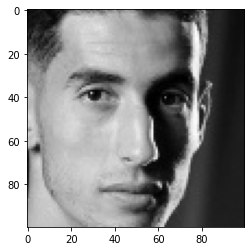

In [5]:
plt.imshow(faces[0], cmap='gray')
print(labels[0])

**Model**

In [7]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import math
import imutils
import time
import cv2
import os

In [8]:
# Convert faces into grayscale
def convertToGray(images):
    faces = []
    for i in range(len(images)):
        img = cv2.cvtColor(images[i] , cv2.COLOR_BGR2GRAY)
        faces.append(img)
    faces = np.array(faces)
    return faces      

In [9]:
faces = convertToGray(faces)

In [10]:
print(type(faces))
print(faces.shape)
print(len(faces))
print(faces[0].shape)

<class 'numpy.ndarray'>
(209, 100, 100)
209
(100, 100)


In [ ]:
le = LabelEncoder()
labels = le.fit_transform(labels)

X_train , X_test , y_train , y_test = train_test_split(faces , labels , test_size = 0.25,
                                                          stratify = labels , random_state = 42, shuffle= True)

recognizer = cv2.face.LBPHFaceRecognizer_create(
        radius = 2 , neighbors = 16 , grid_x = 9 , grid_y  = 9)

recognizer.train(X_train , y_train)

(prediction , conf) = recognizer.predict(X_test)

f1_score = f1_score(y_test,prediction,average="macro")

# generate a sample of testing data
idxs = np.random.choice(range(0 , len(X_test)) , size = 10 , replace = True)
    
for i in idxs:
      # grab the actual and predicted name
      predName = le.inverse_transform([prediction[i]])[0]
      actualName = le.classes_[y_test[i]]

      # grab the face image, convert back it from 1 channel
      # into 3 channels and then resize it
      face = np.dstack([X_test[i]] * 3)
      face = imutils.resize(face , width = 250)

      # draw the actual and predicted name on the image
      cv2.putText(face , "actual : {}".format(actualName) , (5 , 25),
                  cv2.FONT_HERSHEY_SIMPLEX , 0.8 , (0 , 0 , 255) , 2)
      cv2.putText(face , "prediction : {}".format(predName) , (5 , 60),
                  cv2.FONT_HERSHEY_SIMPLEX , 0.8 , (0 , 255 , 0) , 2)
      
      # display the result image and the save it into
      # the desired directory 
      plt.imshow(face , cmap="gray")
      plt.savefig("Predictions_LBP\\face-{}.png".format(i))

In [11]:
def cross_validation(faces, labels, cv = 5 , test_size = 0.25 , output = True , save_model=False):

  # initialize the f1-scores list
  f1_scores = []
    
  # grab some random numbers between 0 and 100
  random_states = np.random.randint(low = 0, high = 100 , size = cv , dtype = int)

  # encode the labels
  le = LabelEncoder()
  labels = le.fit_transform(labels)

  # do the training process based on the number of random_states

  for random_state in random_states:
    # split the data into training and test set
    X_train , X_test , y_train , y_test = train_test_split(faces , labels , test_size = test_size,
                                                          stratify = labels , random_state = random_state, shuffle= True)
    
    # define and train the LBP model
    recognizer = cv2.face.LBPHFaceRecognizer_create(
        radius = 2 , neighbors = 16 , grid_x = 9 , grid_y  = 9)

    recognizer.train(X_train , y_train)

    # initialize our predictions and confidence lists
    predictions = []
    confidence = []

    # loop over the test data
    for i in range(0 , len(X_test)):
      # classify the face and update the predictions
      # and confidence scores
      (prediction , conf) = recognizer.predict(X_test[i])
      predictions.append(prediction)
      confidence.append(confidence)

    # collect and append the calculated f1-score based on this
    # random state
    f1_scores.append(f1_score(y_test,predictions,average="macro"))

  # convert the f1-scores list into Numpy array
  f1_scores = np.array(f1_scores , dtype="float32")

  if output:
    # generate a sample of testing data
    idxs = np.random.choice(range(0 , len(X_test)) , size = 10 , replace = True)

    for i in idxs:
      # grab the actual and predicted name
      predName = le.inverse_transform([predictions[i]])[0]
      actualName = le.classes_[y_test[i]]

      # grab the face image, convert back it from 1 channel
      # into 3 channels and then resize it
      face = np.dstack([X_test[i]] * 3)
      face = imutils.resize(face , width = 250)

      # draw the actual and predicted name on the image
      cv2.putText(face , "actual : {}".format(actualName) , (5 , 25),
                  cv2.FONT_HERSHEY_SIMPLEX , 0.8 , (0 , 0 , 255) , 2)
      cv2.putText(face , "prediction : {}".format(predName) , (5 , 60),
                  cv2.FONT_HERSHEY_SIMPLEX , 0.8 , (0 , 255 , 0) , 2)
      
      # display the result image and the save it into
      # the desired directory 
      plt.imshow(face , cmap="gray")
      plt.savefig("Predictions_LBP\\face-{}.png".format(i))
     
  # save the model
  if save_model:
    # save the model 
    recognizer.save("face-recognizer-model.yml")

  return f1_scores

In [ ]:
f1_scores = cross_validation(faces, labels, cv=5 , save_model=True)